In [1]:
import rasterio
from rasterio.mask import mask
import geopandas as gp
import numpy as np
import shapely
from shapely import geometry
from shapely.geometry import shape, Point, LineString, Polygon , mapping
import matplotlib.pyplot as plt
from rasterio.plot import show
import pyproj
from pyproj import CRS
import fiona
import os 
import re
from rasterio.plot import adjust_band
from rasterio.plot import reshape_as_raster, reshape_as_image
import matplotlib.pyplot as plt
from rasterio.plot import show
from pyproj import transform
from pyproj import Proj
import ast
import pandas as pd

In [11]:
from IPython.display import Audio, display
from timeit import default_timer as timer
start = timer()
def alert():
  global start
  end= timer()
  print("\n\nDuration in minutes : " +  str((end - start)/60) + " minutes." )
  display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))

In [2]:
def color_stretch(image, index):
    colors = image[:, :, index].astype(np.float64)
    for b in range(colors.shape[2]):
        colors[:, :, b] = rasterio.plot.adjust_band(colors[:, :, b])
    return colors

In [3]:
def fire_data(index) :
    fires = pd.read_csv("./data/Fires_data/incendios2015.csv", sep=';' , encoding="utf-8",na_values="nan")
    incendio = fires['incendio']==1
    falso_alarme = fires['falso_alarme']==0 
    falso_alarme_tipo = fires['tipo']!='Falso Alarme'
    fogacho = fires['fogacho']==0
    fires = fires[ incendio & falso_alarme & falso_alarme_tipo & fogacho]
    fires.drop([
                   'ano', 
                   'codigo_sgif',
                   'codigo_anpc',
                   'data_primeira_intervencao',
                   'hora_primeira_intervencao',
                   'fonte_alerta',
                   'nut',
                   'ine',
                   'causa', 'reacendimento' , 'agricola',
                   'queimada','falso_alarme','fogacho','incendio','perimetro','aps', 'regiao_prof', 'ugf' 
              ],axis=1, inplace=True)
    fires = fires.sort_values('area_total',  ascending=False)
    fires.dropna()
    fires.head()
    return fires.loc[ int(index) , : ]

In [4]:
def dms2dd(degrees, minutes, seconds, direction):
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    if direction == 'E' or direction == 'N':
        dd *= -1
    return dd;
def dms_to_decimal(text,direction):
    print(text)
    splited = text.split(':')
    degrees = splited[0]
    minutes = splited[1]
    if len(splited) < 3 : 
        return "0"
    else :
        seconds = splited[2].replace('\'', "")
    result = dms2dd(degrees, minutes, seconds, direction)
    print( result )
    return result

In [3]:
def image_true_color(index, img_data_id, images_path ,x1=0,y1=0,DifRes=False) :
    # path to jp2 files
    path = images_path + 'index' + index + '/' + img_data_id
    
    for name_safe in os.listdir(path) :
        if  img_data_id in name_safe :
            safe = name_safe
    
    path = path + '/' + safe + '/GRANULE/'
    semifolder = os.listdir(path)[0]
    path = path + '/' + semifolder + '/IMG_DATA/'
    if DifRes :
        path = path + 'R10m/'
    regexp = re.compile(r'_B0[2348]')
    sentinal_band_paths = [os.path.join(path, f) for f in os.listdir(path) if regexp.search(f) ]
    sentinal_band_paths.sort()
    
    for i in sentinal_band_paths : 
        src = rasterio.open(i,driver='JP2OpenJPEG')
        meta = src.meta
        img_dir = images_path + 'index'+ index + '/'+ img_data_id + "/"

    if not os.path.exists(img_dir):
        os.makedirs(img_dir)

    img_fp = img_dir + 'bands_img_data_' + index +  '.tif'

    if ( not os.path.isfile(img_fp) ):
        # Read metadata of first file and assume all other bands are the same
        with rasterio.open(sentinal_band_paths[0], driver='JP2OpenJPEG') as src0:
            meta = src0.meta

        # Update metadata to reflect the number of layers
        meta.update(count = len(sentinal_band_paths))

        # Read each layer and write it to stack
        with rasterio.open(img_fp, 'w', **meta) as dst:
            for id, layer in enumerate(sentinal_band_paths, start=1):
                with rasterio.open(layer) as src1:
                    dst.write_band(id, src1.read(1))
    full_dataset = rasterio.open(img_fp)
    img_rows, img_cols = full_dataset.shape
    img_bands = full_dataset.count
    with rasterio.open(img_fp) as src:
        img = src.read()[:,  :  ,   :  ]
    inProj = Proj(init='epsg:4326')
    outProj = Proj(init= full_dataset.crs  )

    #fire location
    if (x1==0 and y1==0) :
        index_data = fire_data(index)
        y1 =dms_to_decimal(index_data["lat"],"W")
        x1 =dms_to_decimal(index_data["lon"],"N")
        print(x1,y1)

    x2,y2 = transform(inProj,outProj,x1,y1)
    a = full_dataset.transform

    # x, y to col, row
    col, row = ~a * ( x2 , y2 )


    # 0 to  10980 for this img_data

    xmin = int( col - 200 ) 
    xmax = int( col + 200 ) 
    ymin = int( row - 200 ) 
    ymax = int( row + 200 ) 

    if (xmin < 0) :
        xmin = 0
    if (ymin < 0) :
        ymin = 0
    if (xmax > 10980) :
        xmax = 10980
    if (ymax > 10980) :
        ymax = 10980

    if (xmax < 0) :
        xmax = 100
    if (ymax < 0) :
        ymax = 100
    if (xmin > 10880) :
        xmin = 10880
    if (ymin > 10880) :
        ymin = 10880

    print ( xmin , xmax ,  ymin , ymax )
    img_train = img[:, xmin : xmax ,  ymin : ymax ]

    reshaped_img_train = reshape_as_image(img_train)

    fig, axs = plt.subplots(1,figsize=(14,14))
    img_stretched_train = color_stretch(reshaped_img_train, [2, 1, 0])
    axs.imshow(img_stretched_train)
    plt.show()

S2A_MSIL1C_20150804T112046_N0204_R037_T29TNE_20150804T112539.SAFE
../../Satellite_img/index10980/_T29TNE_20150804T112539/S2A_MSIL1C_20150804T112046_N0204_R037_T29TNE_20150804T112539.SAFE/GRANULE//L1C_T29TNE_A000606_20150804T112539/IMG_DATA/
['T29TNE_20150804T112046_B02.jp2', 'T29TNE_20150804T112046_B03.jp2', 'T29TNE_20150804T112046_B04.jp2', 'T29TNE_20150804T112046_B08.jp2']
['../../Satellite_img/index10980/_T29TNE_20150804T112539/S2A_MSIL1C_20150804T112046_N0204_R037_T29TNE_20150804T112539.SAFE/GRANULE//L1C_T29TNE_A000606_20150804T112539/IMG_DATA/T29TNE_20150804T112046_B02.jp2', '../../Satellite_img/index10980/_T29TNE_20150804T112539/S2A_MSIL1C_20150804T112046_N0204_R037_T29TNE_20150804T112539.SAFE/GRANULE//L1C_T29TNE_A000606_20150804T112539/IMG_DATA/T29TNE_20150804T112046_B03.jp2', '../../Satellite_img/index10980/_T29TNE_20150804T112539/S2A_MSIL1C_20150804T112046_N0204_R037_T29TNE_20150804T112539.SAFE/GRANULE//L1C_T29TNE_A000606_20150804T112539/IMG_DATA/T29TNE_20150804T112046_B04.jp2

C:\ProgramData\Anaconda3\envs\geo_py37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\ProgramData\Anaconda3\envs\geo_py37\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
C:\ProgramData\Anaconda3\envs\geo_py37\lib\site-packages\IPython\core\interactiveshell.py:3319: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


39:44:22
39.739444444444445
08:29:22
-8.489444444444443
-8.489444444444443 39.739444444444445
543746.1656166404 4398963.358513228
4376.6165616640355 10103.664148677199
4176 4576 9903 10303


Duration in minutes : 5.935641578333335 minutes.


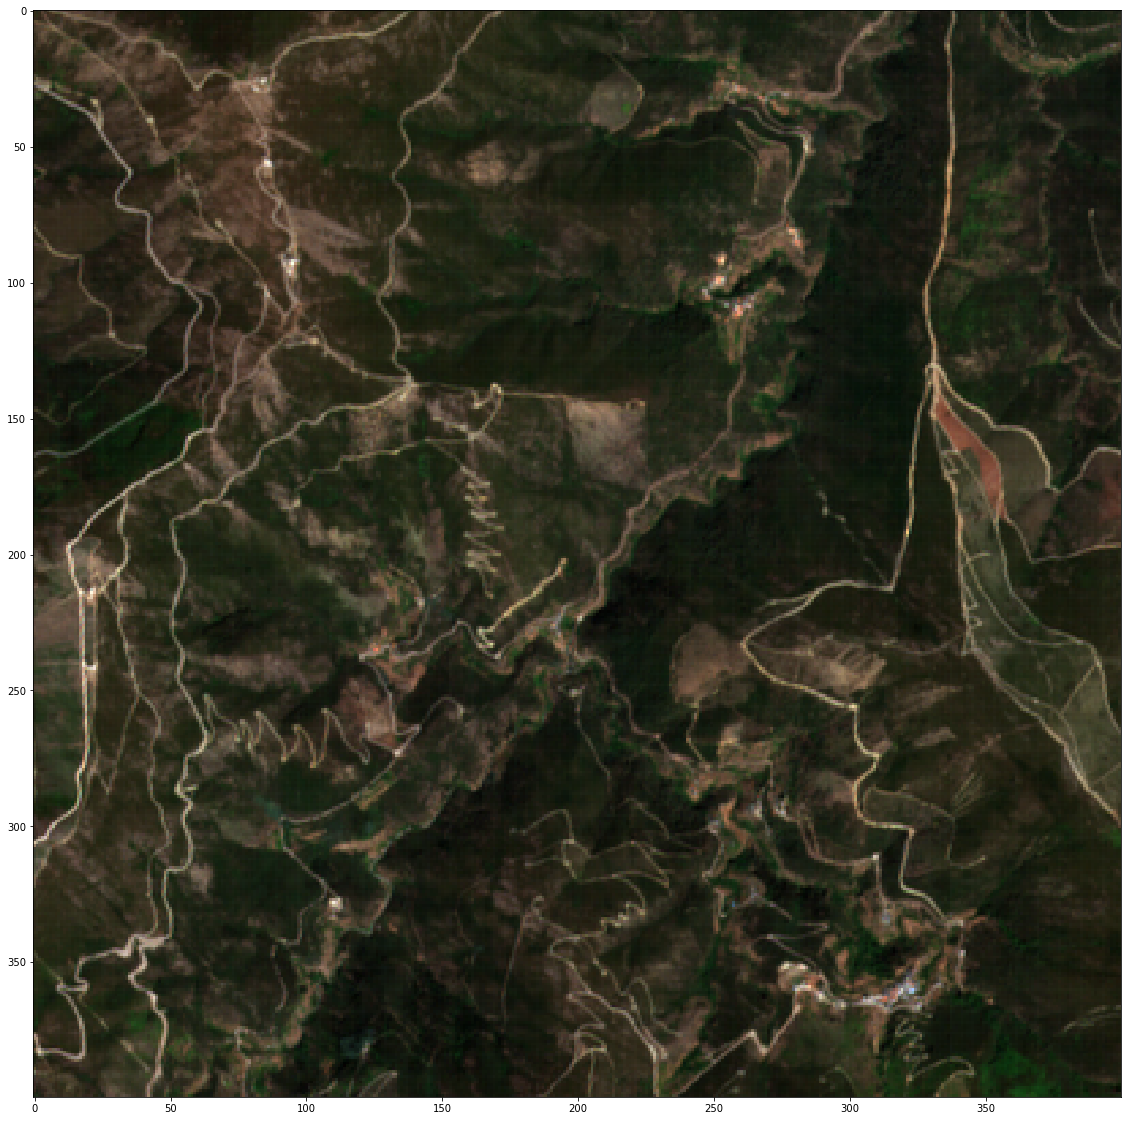

In [19]:
index = '10980' 
img_data_id = '_T29TNE_20150804T112539'
image_true_color(index,img_data_id,"../../Satellite_img/")